In [1]:
#REAL stuff
import sys
sys.path.append("../code/")

import os
import sys
import torch
import argparse
from train import train
from train import *
from cost_functions import BinaryGeneralizeDiceLossV2, BinaryGeneralizeDiceLoss
from torch.optim.adamw import AdamW

2022-04-13 08:40:42.220 | INFO     | train:<module>:21 - SELECTED_COST_FUNCTION = EdgeWeightedBinaryGeneralizeDiceLoss(
  (edge_layer): EdgeWeightingKernel()
)


In [9]:
args_dict = {'data': '../data/training/split/',
 'savedir': '../data/saved_models',
 'logdir': '../data/logs',
 'model': 'pruned_convnext_small',
 'save_images': False,
 'threshold': 0.8}
args = argparse.Namespace(**args_dict)

In [10]:
def compose_cost_functions_additively(*cost_funcs):
  def composition(input_, target):
    cost = 0.
    for func in cost_funcs:
      cost = cost + func(input_, target)
    return cost
  return composition

def log_dice():
  bgdl = BinaryGeneralizeDiceLoss()
  def _log_dice(input_, target):
    return torch.log(1e-7 + bgdl(input_, target))
  return _log_dice

class BinaryGeneralizeDiceLossApadpterForOneChannel(BinaryGeneralizeDiceLoss):
    def forward(self, input_, target):
       # take just first channel
        return super().forward(input_, target)

In [11]:
# state_dict = torch.load("/content/saved_models/cil_experiments/unfrozen_resnet50_ep200/2022-04-03_22-27_epoch144.pkl")

In [12]:
args.model

'pruned_convnext_small'

In [438]:
loss_fn = SELECTED_COST_FUNCTION

In [439]:
#loss = EdgeClassWeightedBinaryGeneralizeDiceLoss()

In [440]:
loss_fn

EdgeWeightedBinaryGeneralizeDiceLoss(
  (edge_layer): EdgeWeightingKernel()
)

# Denoiser CNN

In [16]:
from torch import nn
import torch.nn.functional as F

class DenoiserCNN(nn.Module):
    def __init__(self) -> None:
        # Configuration for tine convnext
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=7, padding="same")
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=1, kernel_size=7, padding="same")
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = F.gelu(self.conv1(x)) # -> torch.Size([1, 512, 25, 25])
        out = torch.sigmoid(self.conv2(out))
        return out

In [17]:
#denoiser = DenoiserCNN()
#denoiser_optimizer = torch.optim.AdamW(denoiser.parameters(), lr=1e-3, weight_decay=1e-2)

# Train

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# Define the paths
assert args.data is not None, "Please specify the path to the training data"

train_dataloader, test_dataloader = get_train_test_dataloaders(args.data)

# Define the model
model = get_model_from_name(model_name=args.model)
#model = torch.load("/content/saved_models/2022-04-04_11-39_epoch98.pkl")
# FIXME: finalize interface for model loading/ keepin requirements of weight sharing in mind
# model = torch.load("/content/saved_models/cil_experiments/unfrozen_resnet50_ep200/2022-04-03_22-27_epoch144.pkl")

# Define the optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40,100], gamma=0.5)

# Choose a loss
# loss =  BinaryGeneralizeDiceLoss() #compose_cost_functions_additively(weighted_BCELoss, BinaryGeneralizeDiceLoss())
print(f"Loss: {loss}")

model = train(model,
              loss_fn=loss_fn,
              optimizer=optimizer,
              scheduler=scheduler,
              n_epochs=200,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              model_save_path=args.savedir,
              logs_save_path=args.logdir,
              save_freq=10,
              logging_freq=10,
              device=device,
              initial_epochs=200,
              threshold=args.threshold)

if args.save_images:
    write_images(model, train_dataloader, "./images/train", args.threshold)
    write_images(model, test_dataloader, "./images/dev", args.threshold)

2022-04-13 08:41:18.780 | DEBUG    | model_convnext:_getter:147 - Loadin weights from : ../data/saved_models/torch/convnext/convnext_tiny-983f1562.pth


Using device: cuda


2022-04-13 08:41:19.797 | DEBUG    | model_convnext:_getter:152 - Missing Keys: ['transpose_block1.0.weight', 'transpose_block1.0.bias', 'transpose_block1.1.weight', 'transpose_block1.1.bias', 'transpose_block1.1.running_mean', 'transpose_block1.1.running_var', 'transpose_block2.0.weight', 'transpose_block2.0.bias', 'transpose_block2.1.weight', 'transpose_block2.1.bias', 'transpose_block2.1.running_mean', 'transpose_block2.1.running_var', 'transpose_block3.0.weight', 'transpose_block3.0.bias', 'transpose_block3.1.weight', 'transpose_block3.1.bias', 'transpose_block3.1.running_mean', 'transpose_block3.1.running_var', 'transpose_block4.0.weight', 'transpose_block4.0.bias', 'transpose_block4.1.weight', 'transpose_block4.1.bias', 'transpose_block4.1.running_mean', 'transpose_block4.1.running_var', 'transpose_block5.0.weight', 'transpose_block5.0.bias', 'transpose_block5.1.weight', 'transpose_block5.1.bias', 'transpose_block5.1.running_mean', 'transpose_block5.1.running_var', 'conv_final.we

Loss: EdgeWeightedBinaryGeneralizeDiceLoss(
  (edge_layer): EdgeWeightingKernel()
)
Starting training a PrunedConvnext(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2

In [ ]:
torch.save(model, "__temp_model.pt")

# Denoiser

In [426]:
import torch
from torch import nn
from torch.nn import functional as F

class DenoiserVAE(nn.Module):


    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 encoder_hidden_dims: list,
                 decoder_hidden_dims: list,
                 encoder_hidden_config: list,
                 decoder_hidden_config: list,
                 smallest_size: int, # size of image in bottleneck
                 loss_fn: callable,
                 out_channels = 1,
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.smallest_size = smallest_size
        self.last_channels = encoder_hidden_dims[-1]
        self.loss_fn = loss_fn
        
        encoder_hidden_dims = [in_channels] + encoder_hidden_dims
        decoder_hidden_dims = decoder_hidden_dims + [in_channels]

        modules = []

        # Build Encoder
        for i, h_config in enumerate(encoder_hidden_config):
            modules.append(
                nn.Sequential(
                    nn.Conv2d(encoder_hidden_dims[i], out_channels=encoder_hidden_dims[i+1],
                              kernel_size=h_config['kernel_size'], stride= h_config['stride'], padding=h_config['padding']),
                    nn.BatchNorm2d(encoder_hidden_dims[i+1]),
                    nn.LeakyReLU())
            )
            in_channels = encoder_hidden_dims[i]

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(self.last_channels*smallest_size*smallest_size, latent_dim)
        self.fc_var = nn.Linear(self.last_channels*smallest_size*smallest_size, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, self.last_channels * smallest_size * smallest_size)
        
        for i, h_config in enumerate(decoder_hidden_config):
            layer = [nn.ConvTranspose2d(decoder_hidden_dims[i],
                                       decoder_hidden_dims[i+1],
                                       kernel_size=h_config['kernel_size'],
                                       stride = h_config['stride'],
                                       padding=h_config['padding'],
                                       output_padding=1),
                    nn.BatchNorm2d(decoder_hidden_dims[i+1])]
            
            if i<(len(decoder_hidden_config)-1):
                layer.append(nn.LeakyReLU())
            
            modules.append(
                nn.Sequential(*layer)
            )

        self.decoder = nn.Sequential(*modules)
        
        self.sigmoid = nn.Sigmoid()

    def encode(self, input: torch.Tensor):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, self.last_channels, self.smallest_size, self.smallest_size)
        result = self.decoder(result)
        result = self.sigmoid(result)
        return result

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, original_input: torch.Tensor, **kwargs):
        mu, log_var = self.encode(original_input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), original_input, mu, log_var]

    def loss_function(self,
                      recons,
                      target,
                      mu,
                      log_var,
                      **kwargs) -> dict:
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        #kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        kld_weight = 0.1
        recons_loss = self.loss_fn(recons, target)

        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss.detach(), 'KLD':-kld_loss.detach()}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> torch.Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: torch.Tensor, **kwargs) -> torch.Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [427]:
encoder_hidden_dims = [3, 12, 32, 64, 128, 256]
encoder_hidden_config = [{"kernel_size": 5,
                         "stride": 3,
                         "padding": 1},
                         
                         {"kernel_size": 5,
                         "stride": 3,
                         "padding": 1},
                        
                         {"kernel_size": 3,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 3,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 3,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 3,
                         "stride": 2,
                         "padding": 1}]

In [428]:
decoder_hidden_dims = [256, 128, 64, 32, 12, 6]
decoder_hidden_config = [{"kernel_size": 3,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 3,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 4,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 4,
                         "stride": 4,
                         "padding": 1},
                        
                         {"kernel_size": 4,
                         "stride": 2,
                         "padding": 1},
                        
                         {"kernel_size": 5,
                         "stride": 2,
                         "padding": 1}]

In [445]:
vae = DenoiserVAE(in_channels=1, latent_dim=10, loss_fn=loss_fn,
                  encoder_hidden_dims=encoder_hidden_dims, 
                    decoder_hidden_dims=decoder_hidden_dims,
                  encoder_hidden_config=encoder_hidden_config, 
                  decoder_hidden_config=decoder_hidden_config, 
                  smallest_size=3)

In [446]:
vae_optimizer = torch.optim.AdamW(vae.parameters(),
                               lr=1e-3)

In [447]:
from torchmetrics import F1Score
f1_score = F1Score(threshold=0.5)

In [448]:
n_epochs = 30
vae = vae.to('cuda')

for n in range(n_epochs):
    for i, (inp, target) in enumerate(train_dataloader):
        with torch.no_grad():
            model_prediction = model.forward(inp.to('cuda'))
            
        # VAE forward pass
        reconstructed, _, mu, log_var = vae.forward(model_prediction)
        loss_info = vae.loss_function(reconstructed, target.to('cuda'), mu, log_var)
        loss = loss_info['loss']
        
        # compute the gradients
        vae_optimizer.zero_grad()
        loss.backward()

        # optimizer step
        vae_optimizer.step()
    
    with torch.no_grad():
        predictions_model = []
        predictions_denoised = []
        targets = []

        for i, (inp, target) in enumerate(test_dataloader):
            # move input to cuda if required
            if device == "cuda":
                inp = inp.cuda(non_blocking=True)
                target = target.cuda(non_blocking=True)

            # forward pass
            pred = model.forward(inp)
            pred_denoised, _, _, _ = vae.forward(pred)
            
            predictions_model.append(pred)
            predictions_denoised.append(pred_denoised)
            targets.append(target)

        targets = torch.cat(targets, axis=0)
        predictions_model = torch.cat(predictions_model, axis=0)
        predictions_denoised = torch.cat(predictions_denoised, axis=0)
        f1_value_model = f1_score(predictions_model.to('cpu'), targets.int().to('cpu')[:, 0])
        f1_value_denoised = f1_score(predictions_denoised.to('cpu'), targets.int().to('cpu')[:, 0])
        
        print(f"[Epoch {n+1}/{n_epochs}] => F1-model: {f1_value_model} | F1-denoiser: {f1_value_denoised}")

[Epoch 1/30] => F1-model: 0.7831563949584961 | F1-denoiser: 0.2746482789516449
[Epoch 2/30] => F1-model: 0.7831563949584961 | F1-denoiser: 0.2807229459285736
[Epoch 3/30] => F1-model: 0.7831563949584961 | F1-denoiser: 0.28467896580696106
[Epoch 4/30] => F1-model: 0.7831563949584961 | F1-denoiser: 0.28249499201774597


KeyboardInterrupt: 

In [ ]:
vae.decoder

# Visualize

In [371]:
import matplotlib.pyplot as plt
# FIXME: splits seed is not fixed - we may get training/test data will get mixed
# up in second run
train_dataloader, test_dataloader = get_train_test_dataloaders(args.data)

test_image_index = -1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.3523, device='cuda:0', grad_fn=<MinBackward1>)


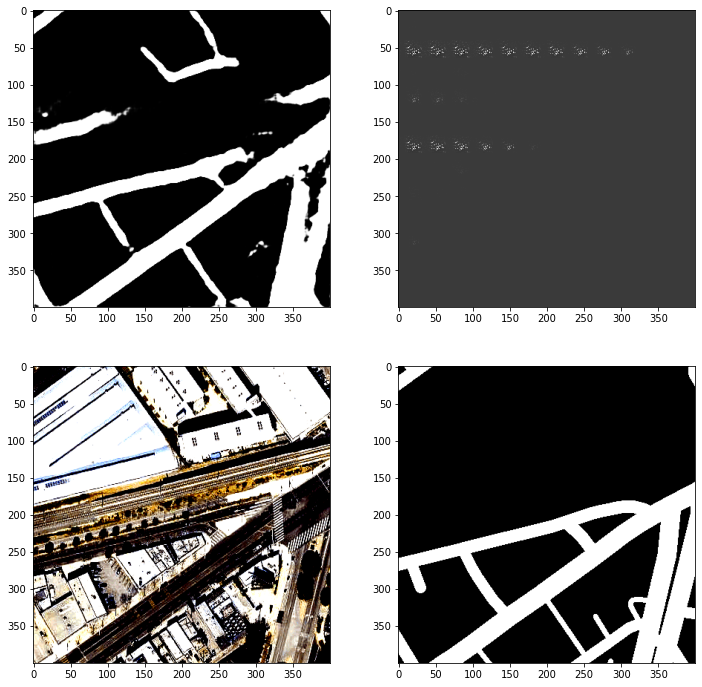

In [382]:
test_image_index += 1

test_image, test_target = test_dataloader.dataset[test_image_index]
pred = model(test_image.unsqueeze(0).to('cuda'))[0]
pred_rounded, _, _, _ = vae.forward(pred.unsqueeze(0))

fig, ax = plt.subplots(2, 2, figsize=(12, 12))
im = ax[0, 0].imshow(pred.squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[0, 1].imshow(pred_rounded.squeeze(0).squeeze(0).detach().cpu().numpy() * 255, cmap='gray')
im = ax[1, 0].imshow(test_image.permute(1, 2, 0).detach().cpu().numpy())
im = ax[1, 1].imshow(test_target[0].detach().cpu().numpy() * 255, cmap='gray')

plt.show()